# Gradiente Descendente Paralelo 
#### Estudo de Abordagens de Implementação
---
**Créditos:**
 Adaptação do código original desenvolvido por [Angad Gill](https://github.com/angadgill) e [Sharath Rao](https://github.com/sharathrao13) com base no paper de Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). [Parallelized stochastic gradient descent](http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent). 

## Dataset

Dataset Diamonds, blablabl
~52000 observações com 8 características e preços correspondentes de diamantes, para regressão linear.

In [1]:
%matplotlib inline
from sklearn.datasets import make_regression
from sklearn.model_selection import ShuffleSplit
import numpy as np
from matplotlib import pyplot as plt
import utils
import importlib
importlib.reload(utils)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
n_samples = 800
seed = 1

import pandas as pd

# Carregar dados 
df = pd.read_csv('diamond_prices.csv', header=0)

# Normalizar dados
df = (df - df.mean()) / (df.max() - df.min())

# Selecionar amostra
dfn = df.sample(n=n_samples, random_state=seed) 

# Selecionar features e labels
# Duas variáveis: X = df[['carat', 'cut_code']]
X = dfn[['carat','depth','table','x','y','z', 'cut_code', 'color_code', 'clarity_code' ]]
y = dfn[['price']]

X = np.array(X)
y = np.array(y).ravel()

Preparação dos conjuntos para treinamento e testes:

In [3]:
rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)

In [4]:
for train_index, test_index in rs.split(X):
    pass

In [5]:
X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

## 
## SGD "Normal" (baseline)

Treinameno do modelo com coleta da taxa de acurácia a cada iteração:

In [6]:
from sklearn.linear_model import SGDRegressor

In [7]:
# Número máximo de iterações:
n_iter = 500

In [8]:
# Modelo dde regressão do SciKit-Learn
sgd = SGDRegressor(max_iter = n_iter, tol = 0.001)

In [9]:
# Treinamento do modelo e estatísticas
%time sgd.fit(X_train, y_train)

CPU times: user 1.65 ms, sys: 472 µs, total: 2.12 ms
Wall time: 991 µs


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=500,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [10]:
# Availiação
scores_base = []
cost_base = []
sgd = SGDRegressor(max_iter=1, tol=0.001, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores_base += [sgd.score(X_test, y_test)]
    cost_base += [utils.computeCost(X_test,y_test,sgd.coef_)]

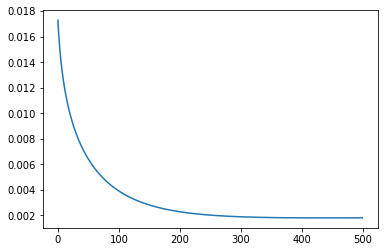

In [11]:
#plt.plot(range(len(scores_base)), scores_base)
plt.plot(range(len(cost_base)),cost_base)

In [12]:
# Acurácia final
scores_base[-1]

0.9042346937524806


# SGD Paralelo
Comparação de diferentes abordagens de paralelização

In [13]:
from joblib import Parallel, delayed
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

### Cenário 1:
Neste cenário o dataset é dividido em partes iguais e cada uma é atribuída a um worker. Os pesos (parâmetros) finais são calculados uma única vez quando todos terminam o processamento.

In [14]:
# Quantidade de workers
n_jobs = 4

# Treinamento
%time scores,costs, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

CPU times: user 763 ms, sys: 271 µs, total: 763 ms
Wall time: 766 ms


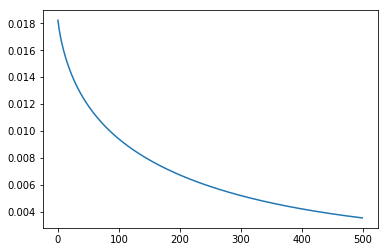

In [15]:
plt.plot(range(len(costs)),costs)

### Cenário 2:
Neste cenário, todos os workers tem acesso a todo o conjunto de dados. Os pesos são finais são calculados uma única vez quando todos terminam o processamento.

4 workers:

In [16]:
n_jobs = 4
%time scores_4,costs_4, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 1.01 s, sys: 28.8 ms, total: 1.04 s
Wall time: 1 s


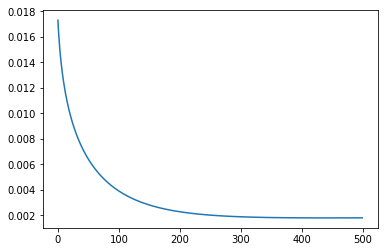

In [17]:
plt.plot(range(len(costs_4)),costs_4)

20 workers:

In [18]:
n_jobs = 20
%time scores_20, costs_20, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 4.53 s, sys: 25.6 ms, total: 4.55 s
Wall time: 4.5 s


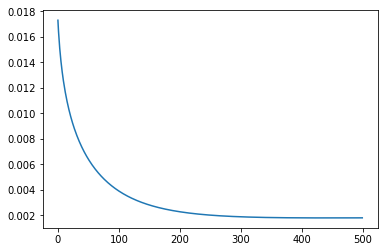

In [19]:
plt.plot(range(len(costs_20)),costs_20)

50 workers:

In [20]:
n_jobs = 50
%time scores_50, costs_50, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 11.4 s, sys: 91.1 ms, total: 11.5 s
Wall time: 11.4 s


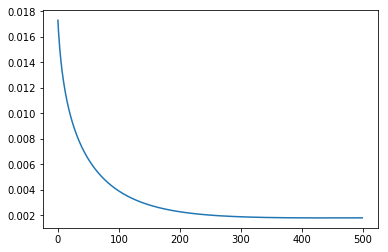

In [21]:
plt.plot(range(len(costs_50)),costs_50)

100 workers:

In [22]:
n_jobs = 100
%time scores_100, costs_100, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 23.3 s, sys: 136 ms, total: 23.4 s
Wall time: 23.3 s


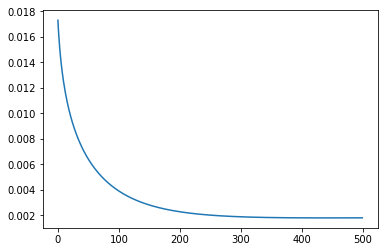

In [23]:
plt.plot(range(len(costs_100)),costs_100)

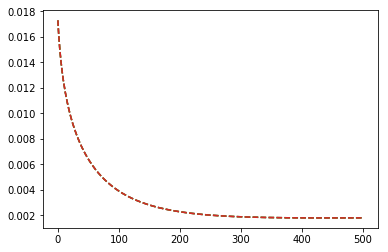

In [24]:
plt.figure(1)
for s in [costs_4, costs_20, costs_50, costs_100]:
    plt.plot(range(len(s)),s, '--')

### Cenário 3:
Neste cenário uma porcentagem dos dados é distribuída a cada worker. O mesmo exemplo pode ser acessado por mais de um deles (overlap). A sincronização é feita apenas ao final.

50% dos dados para cada worker:

In [25]:
n_jobs = 4
%time scores, costs, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

CPU times: user 824 ms, sys: 39 µs, total: 824 ms
Wall time: 825 ms


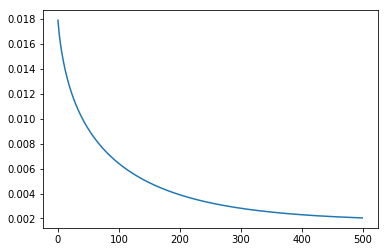

In [26]:
plt.plot(range(len(costs)),costs)

25% dos dados para cada worker:

In [27]:
n_jobs = 4
%time scores, costs,theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

CPU times: user 771 ms, sys: 15 µs, total: 771 ms
Wall time: 770 ms


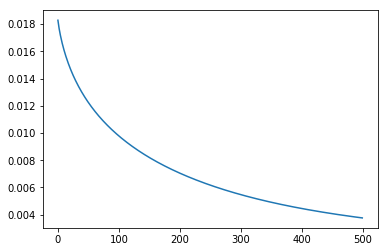

In [28]:
plt.plot(range(len(costs)),costs)

### Cenário 4:
No cenário 4, todos os workers processam todo o conjunto de dados, mas a sincronização dos resultados é feita não apenas ao final, mas também durante o processamento.

Com 2 sincronizações:

In [29]:
importlib.reload(utils)

<module 'utils' from '/home/jeff/github/gdp/utils.py'>

In [30]:
n_jobs = 4
n_sync = 2
%time scores_2_sync, costs_2_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 250
CPU times: user 1.13 s, sys: 40.1 ms, total: 1.17 s
Wall time: 1.12 s


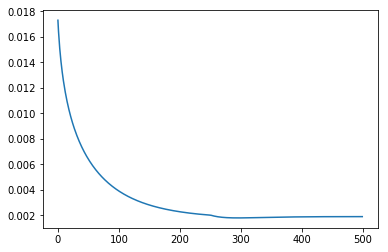

In [31]:
plt.plot(range(len(costs_2_sync)),costs_2_sync)

Com 4 sincronizações:

In [32]:
n_jobs = 4
n_sync = 4
%time scores_4_sync, costs_4_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 125
Synced at iteration: 250
Synced at iteration: 375
CPU times: user 1.06 s, sys: 40.2 ms, total: 1.1 s
Wall time: 1.07 s


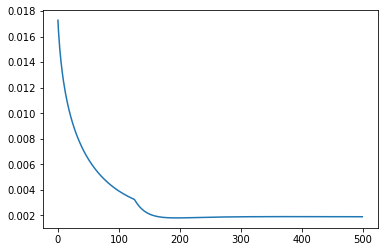

In [33]:
plt.plot(range(len(costs_4_sync)),costs_4_sync)

Com 5 sicncronizações:

In [34]:
n_jobs = 4
n_sync = 5
%time scores_5_sync, costs_5_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 100
Synced at iteration: 200
Synced at iteration: 300
Synced at iteration: 400
CPU times: user 1.14 s, sys: 24.5 ms, total: 1.16 s
Wall time: 1.12 s


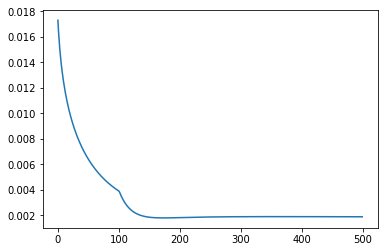

In [35]:
plt.plot(range(len(costs_5_sync)),costs_5_sync)

Com 10 sincronizações:

In [36]:
n_jobs = 4
n_sync = 10
%time scores_10_sync, costs_10_sync, theta = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 50
Synced at iteration: 100
Synced at iteration: 150
Synced at iteration: 200
Synced at iteration: 250
Synced at iteration: 300
Synced at iteration: 350
Synced at iteration: 400
Synced at iteration: 450
CPU times: user 1.16 s, sys: 24.6 ms, total: 1.18 s
Wall time: 1.13 s


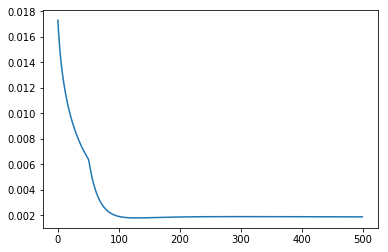

In [37]:
plt.plot(range(len(costs_10_sync)),costs_10_sync)

Comparativo dos testes:

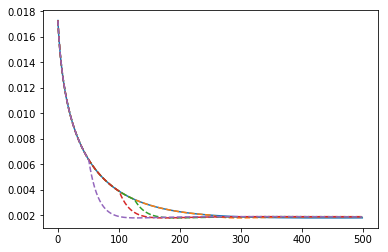

In [38]:
plt.figure(1)
plt.plot(range(len(cost_base)), cost_base)
for s in [costs_2_sync, costs_4_sync, costs_5_sync, costs_10_sync]:
    plt.plot(range(len(s)), s, '--')